In [1]:
import numpy as np
import scipy as sp
import chemiscope
import featomic
import ase.io
from tqdm import tqdm
import metatensor.operations as mto
from metatensor import Labels
import matplotlib.pyplot as plt

# Time correlations

In [2]:
stride = 4
frames = ase.io.read("/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/data/GeTe/ramp_up.pos_0.extxyz", "1000:")[::stride] + ase.io.read("/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/data/GeTe/ramp_down.pos_0.extxyz", ":-500")[::stride]
for f in frames:
    f.wrap()

In [3]:
len(frames)

1627

In [4]:
# hypers for evaluating features
hypers = {
    "cutoff": {"radius": 8, "smoothing": {"type": "ShiftedCosine", "width": 8}},
    "density": {"type": "Gaussian", "width": 2.0},
    "basis": {
        "type": "TensorProduct",
        "max_angular": 6,
        "radial": {"type": "Gto", "max_radial": 4},
    },
}
# gets only Te-centered features
selection = Labels(
    names=["center_type"],
    values=np.array([[52]], dtype=np.int32),
)
calculator = featomic.SoapPowerSpectrum(**hypers)

In [5]:
rho2i_0 = calculator.compute(frames[0]) # , selected_keys=selection)
rho2i_0 = rho2i_0.keys_to_samples(["center_type"]).keys_to_properties(
    ["neighbor_1_type", "neighbor_2_type"]
)
rho2i_values = rho2i_0.block(0).values
print(rho2i_values.shape)

(512, 525)


In [6]:
maxlag=200
atomsel=np.arange(0,len(frames[0]),16) # selects only a few atoms so it fits into memory
ige = np.arange(len(atomsel)//2)
ite = ige+(len(atomsel)//2)

In [7]:
buffer = np.zeros((len(atomsel),maxlag,rho2i_values.shape[1]))
corrcov = np.zeros((2, maxlag, rho2i_values.shape[1],rho2i_values.shape[1],))
soapsum = np.zeros((2 ,rho2i_values.shape[1],))

In [9]:
nsmp = 0
for fidx, frame in tqdm(enumerate(frames), total=len(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    
    if fidx>=maxlag:
        first = buffer[:,fidx%maxlag]
        roll_idx = np.roll(np.arange(maxlag), -fidx%maxlag)
        # computes a contribution to the correlation function
        # the buffer contains data from fidx-maxlag to fidx. add a forward ACF
        newcov = np.einsum("ia,ijb->jab", first[ige], buffer[ige][:,roll_idx])
        corrcov[0] += newcov
        newcov = np.einsum("ia,ijb->jab", first[ite], buffer[ite][:,roll_idx])
        corrcov[1] += newcov
        
        soapsum[0] += first[ige].sum(axis=0)
        soapsum[1] += first[ite].sum(axis=0)
        
        nsmp += len(ige)
        
    buffer[:,fidx%maxlag] = new_soap

100%|██████████| 1627/1627 [1:30:00<00:00,  3.32s/it]


In [590]:
# autocorrelation matrix - remove mean
corrcc = corrcov/nsmp - soapsum[:, None, :, None]* soapsum[:, None, None, :]/(nsmp**2)

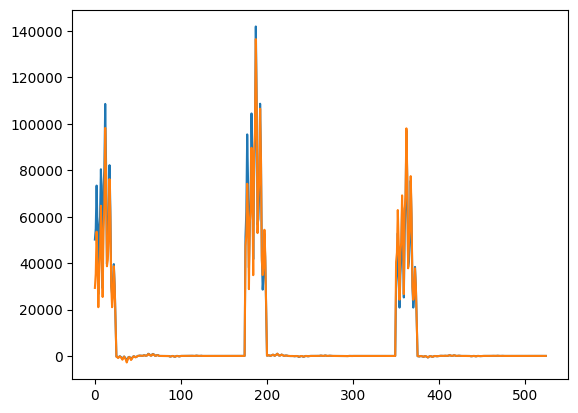

In [533]:
plt.plot(soapsum[0])
plt.plot(soapsum[1])

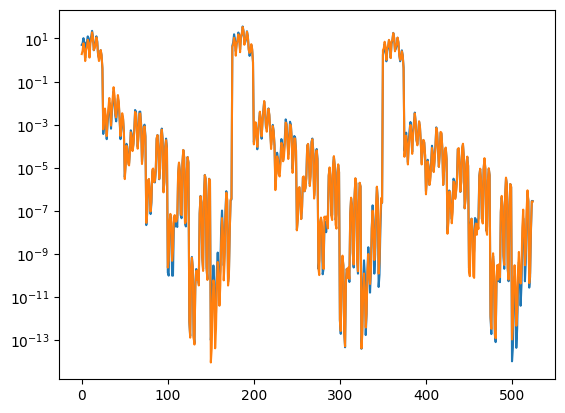

In [591]:
plt.semilogy(np.diagonal(corrcc[0,0]))
plt.semilogy(np.diagonal(corrcc[1,0]))

In [535]:
# autocorrelation matrix - normalize
#for iat in range(len(atomsel)):
#    nrm = np.sqrt(np.diagonal(corrcc[0,iat]))
#    corrcc[:,iat] /= (nrm[:, None]*nrm[None,:])[None, :, :]

In [536]:
corrcc.shape

(2, 200, 525, 525)

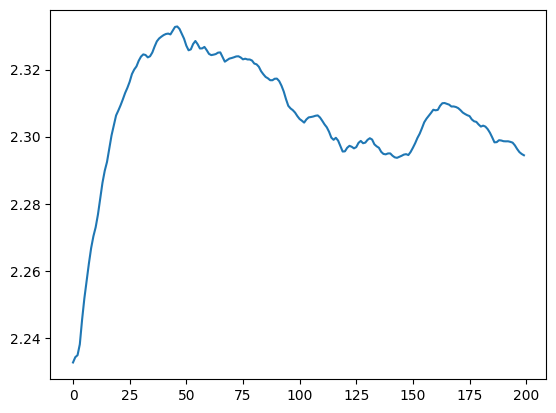

In [592]:
plt.plot(corrcc[0,:,1,350])

In [593]:
sigma = corrcc.sum(axis=1)
sigma0 = corrcc[:, 0]

In [594]:
corrcc.shape

(2, 200, 525, 525)

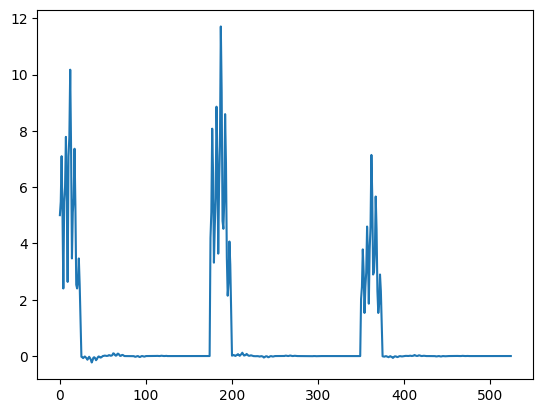

In [595]:
plt.plot(sigma0[0,0])

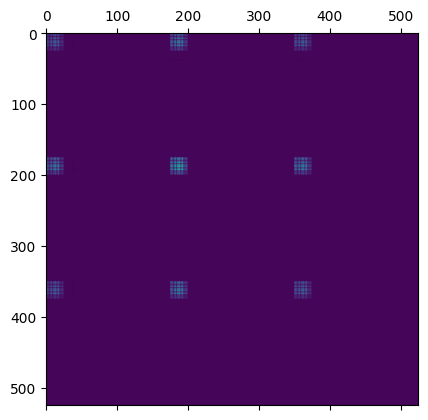

In [596]:
plt.matshow(sigma[1])

In [604]:
alleva, alleve = [None, None], [None, None]
for i in range(2):
    alleva[i], alleve[i] = sp.linalg.eigh(0.5*(sigma[i]+sigma[i].T), 
                                0.5*(sigma0[i]+sigma0[i].T)
                                +np.eye(len(sigma0[i]))*1e-5)
alleva = np.array(alleva)
alleve = np.array(alleve)

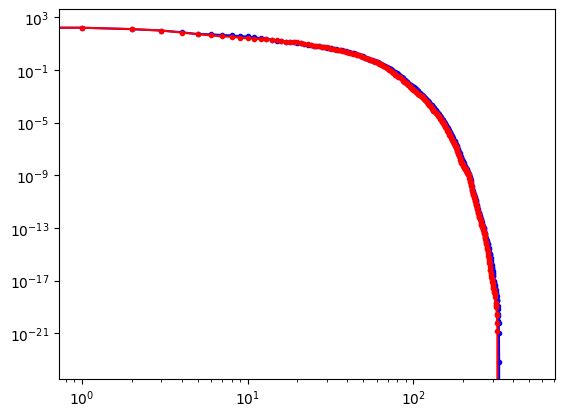

In [605]:
plt.loglog(alleva[0][::-1], 'b.-')
plt.loglog(alleva[1][::-1], 'r.-')

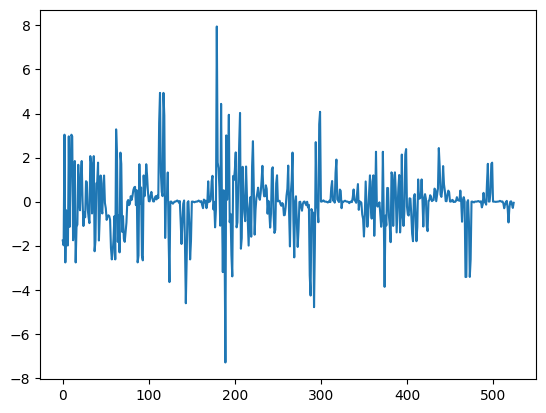

In [603]:
plt.plot(alleve[0][:,-1])

In [545]:
u0 = eigvec[:,-4]

In [546]:
c00=np.einsum("ijab,a,b->ij", corrcc, u0, u0)

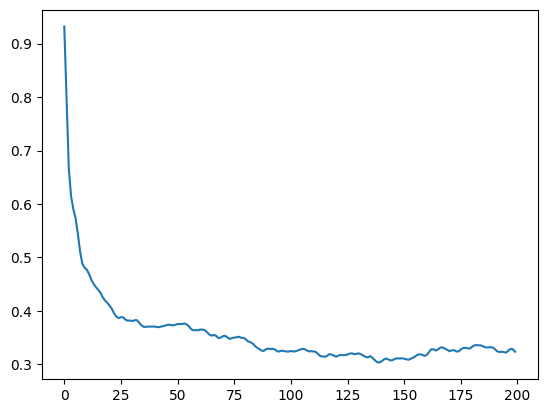

In [547]:
plt.plot(c00[0])

In [617]:
alleve[0].shape
new_soap[ige].shape

(8, 525)

In [624]:
npca = 40
trj_act = np.zeros((len(frames),len(atomsel),npca) )
for fidx, frame in tqdm(enumerate(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    trj_act[fidx] = np.vstack([
        np.einsum("ba,ib->ia", alleve[...,::-1][0,:,:npca], new_soap[ige]),
        np.einsum("ba,ib->ia", alleve[...,::-1][1,:,:npca], new_soap[ite])    
    ])

1627it [04:18,  6.31it/s]


In [625]:
trj_act.shape

(1627, 16, 40)

In [626]:
trj_act[:,0,0]

array([0.52140916, 0.49678704, 0.47150117, ..., 1.67692417, 1.62636676,
       1.58904297])

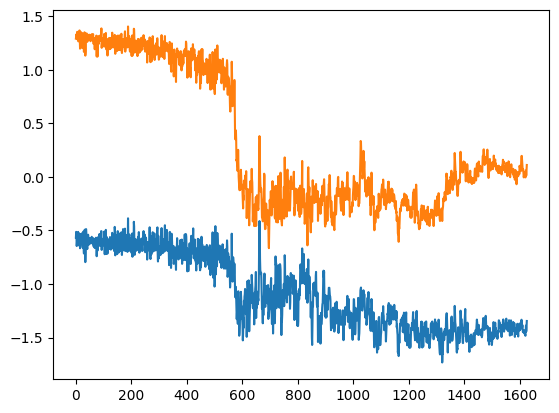

In [643]:
plt.plot(trj_act[:,-1,0])
plt.plot(trj_act[:,-1,1])

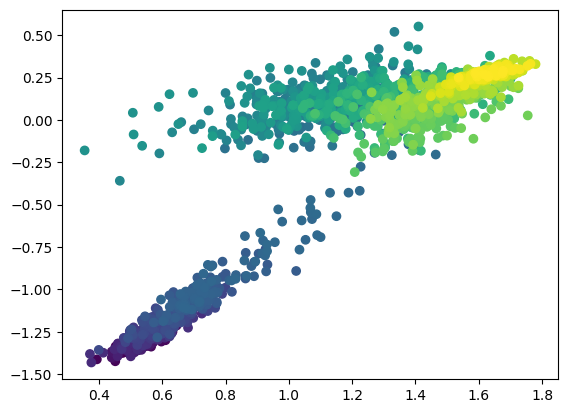

In [646]:
plt.scatter(trj_act[:,0,0], trj_act[:,0,1], c=np.arange(len(trj_act)), linestyle='-')

# Running averaging

In [647]:
stride = 4
frames = ase.io.read("ramp_up.pos_0.extxyz", "1000:")[::stride] + ase.io.read("ramp_down.pos_0.extxyz", ":-500")[::stride]
for f in frames:
    f.wrap()

In [648]:
len(frames)

1627

In [649]:
# hypers for evaluating features
hypers = {
    "cutoff": {"radius": 8, "smoothing": {"type": "ShiftedCosine", "width": 8}},
    "density": {"type": "Gaussian", "width": 2.0},
    "basis": {
        "type": "TensorProduct",
        "max_angular": 6,
        "radial": {"type": "Gto", "max_radial": 4},
    },
}
# gets only Te-centered features
selection = Labels(
    names=["center_type"],
    values=np.array([[52]], dtype=np.int32),
)
calculator = featomic.SoapPowerSpectrum(**hypers)

In [650]:
rho2i_0 = calculator.compute(frames[0]) # , selected_keys=selection)
rho2i_0 = rho2i_0.keys_to_samples(["center_type"]).keys_to_properties(
    ["neighbor_1_type", "neighbor_2_type"]
)
rho2i_values = rho2i_0.block(0).values
print(rho2i_values.shape)

(512, 525)


In [651]:
maxlag=100
atomsel=np.arange(0,len(frames[0]),32) # selects only a few atoms so it fits into memory
ige = np.arange(len(atomsel)//2)
ite = ige+(len(atomsel)//2)

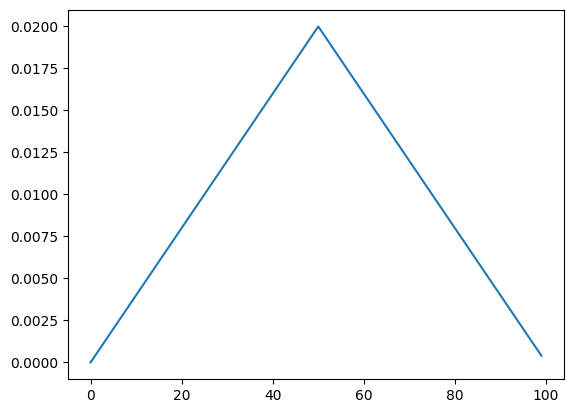

In [652]:
kernel = 1-np.abs(np.arange(maxlag)-maxlag/2)*2/maxlag
kernel /= kernel.sum()
plt.plot(kernel)

In [653]:
buffer = np.zeros((len(atomsel), maxlag, rho2i_values.shape[1]))
avgcov = np.zeros((2, rho2i_values.shape[1], rho2i_values.shape[1],))
soapsum = np.zeros((2 ,rho2i_values.shape[1],))

In [654]:
nsmp = 0
for fidx, frame in tqdm(enumerate(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    
    if fidx>=maxlag:
        first = buffer[:,fidx%maxlag]
        roll_kernel = np.roll(kernel, -fidx%maxlag)
        # computes a contribution to the correlation function
        # the buffer contains data from fidx-maxlag to fidx. add a forward ACF        
        avg_soap = np.einsum("j,ija->ia", roll_kernel, buffer)
        soapsum[0] += avg_soap[ige].sum(axis=0)
        soapsum[1] += avg_soap[ite].sum(axis=0)        
        # ge and te averaged covariance
        avgcov[0] += np.einsum("ia,ib->ab", new_soap[ige], new_soap[ige])
        avgcov[1] += np.einsum("ia,ib->ab", new_soap[ite], new_soap[ite])
        
        nsmp += len(ige)        
        
    buffer[:,fidx%maxlag] = new_soap

1627it [03:43,  7.27it/s]


In [655]:
# autocorrelation matrix - remove mean
avgcc = avgcov/nsmp - soapsum[:, :, None]* soapsum[:, None, :]/(nsmp**2)

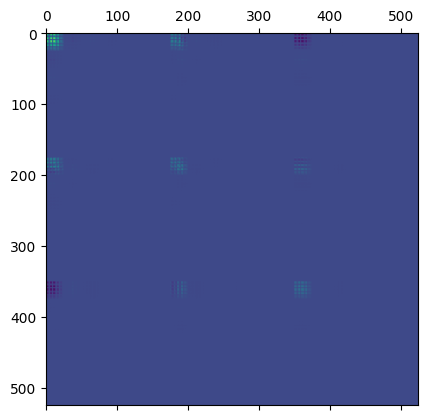

In [656]:
plt.matshow(avgcc[0])

In [663]:
alleva, alleve = [None, None], [None, None]
for i in range(2):
    alleva[i], alleve[i] = sp.linalg.eigh(0.5*(avgcc[i]+avgcc[i].T))
alleva = np.array(alleva)
alleve = np.array(alleve)

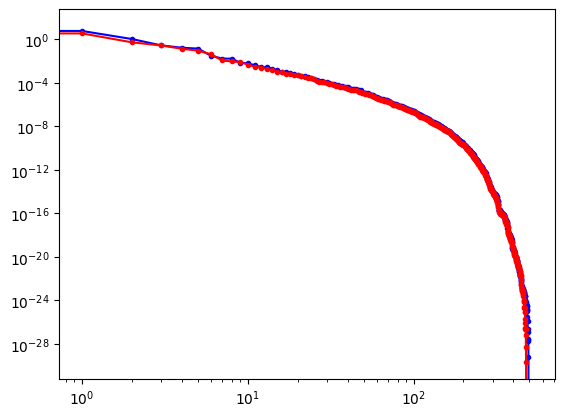

In [664]:
plt.loglog(alleva[0][::-1], 'b.-')
plt.loglog(alleva[1][::-1], 'r.-')

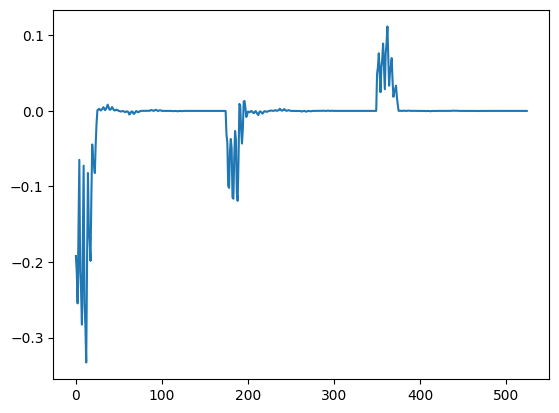

In [665]:
plt.plot(alleve[0][:,-1])

In [666]:
npca = 40
trj_avg = np.zeros((len(frames),len(atomsel),npca) )
for fidx, frame in tqdm(enumerate(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    trj_avg[fidx] = np.vstack([
        np.einsum("ba,ib->ia", alleve[...,::-1][0,:,:npca], new_soap[ige]),
        np.einsum("ba,ib->ia", alleve[...,::-1][1,:,:npca], new_soap[ite])    
    ])

1627it [02:54,  9.32it/s]


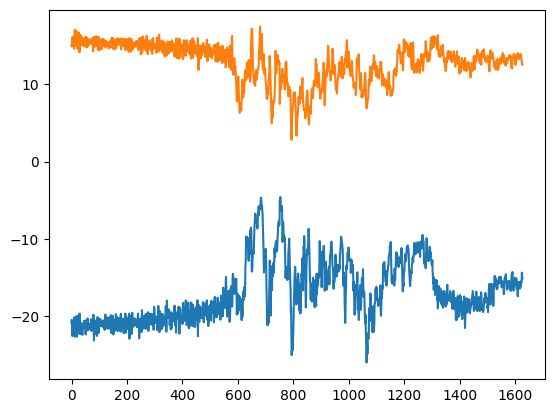

In [669]:
plt.plot(trj_avg[:,-1,0])
plt.plot(trj_avg[:,-1,1])

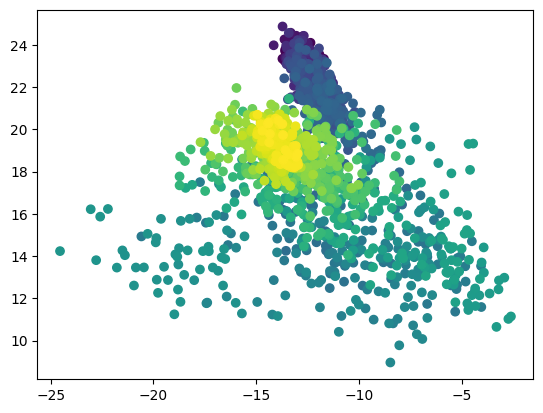

In [670]:
plt.scatter(trj_avg[:,0,0], trj_avg[:,0,1], c=np.arange(len(trj_avg)), linestyle='-')

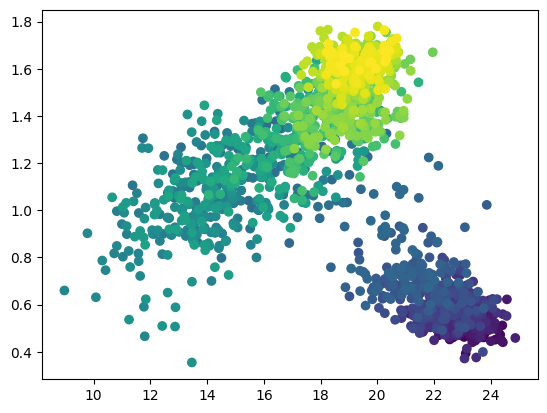

In [677]:
plt.scatter(trj_avg[:,0,1], trj_act[:,0,0], c=np.arange(len(trj_avg)), linestyle='-')

# Chemiscope the f**k out of it

In [686]:
cs=chemiscope.show(frames,
                properties={
                    "act[0]": trj_act[...,0].flatten(),
                    "act[1]": trj_act[...,1].flatten(),
                    "avg[0]": trj_avg[...,0].flatten(),
                    "avg[1]": trj_avg[...,1].flatten(),
                },
                environments = [[i,j,4] for i in range(len(frames)) for j in atomsel],
                settings=chemiscope.quick_settings(periodic=True, trajectory=True, target="atom", map_settings={"joinPoints": False})
               )

In [684]:
cs.settings

{'map': {'joinPoints': True},
 'structure': [{'keepOrientation': True,
   'playbackDelay': 50,
   'unitCell': True,
   'supercell': [3, 3, 3]}],
 'target': 'atom'}

In [688]:
cs

<ChemiscopeWidget(meta={'name': ' '}, settings={'map': {'joinPoints': False}, 'structure': [{'keepOrientation'…

In [689]:
cs.save("gete-avg-test.chemiscope.json")